In [3]:
import numpy as np
import pandas as pd
import glob as glob
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
%matplotlib inline
plt.style.use('fivethirtyeight')
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<a href="javascript:code_toggle()">Show/Hide Code</a>.''')

In [6]:
def get_meridios_quality_history_csv(provider, csv):
    df = pd.read_csv(csv, usecols=["lastupdate", "metricname", "ptsseen_avg"], parse_dates=["lastupdate"])
    df['Provider'] = provider.replace("_", " ")
    # Normalize last update to just a date (not specific run time)
    df['lastupdate'] = df['lastupdate'].apply(lambda dt: datetime.datetime(dt.year, dt.month, dt.day))
    return df

def basic_trendline(dataframe, chart, column, metrictitle, threshold):
    dataframe[column].plot(ax=chart, legend=False)
    chart.set(title=metrictitle, ylim=(0,100), xlabel="")
    chart.axhline(y=threshold, color='g', label='Target', linestyle='--', linewidth=1, zorder=5)
    chart.xaxis.set_major_formatter(plt.NullFormatter())
    
def create_individual_core_quality_graphs(individual, clinic):
    dfs = []
    dfs.append(get_meridios_quality_history_csv('FCN',"FCN.csv"))
    dfs.append(get_meridios_quality_history_csv(clinic, ('./clinic/' + clinic + '.csv')))
    dfs.append(get_meridios_quality_history_csv(individual, ('./provider/' + individual + '.csv')))   
    big_frame = pd.concat(dfs, ignore_index=True)
    big_frame = big_frame.pivot_table(index='lastupdate', columns=['metricname','Provider'], values="ptsseen_avg")
    
    # Summary Graph
    fig, ax = plt.subplots(nrows=3, ncols=3, sharey=True, figsize=(9,9))
    fig.suptitle(individual.replace('_'," ") + ": Core Quality Measures", fontsize=24)
    
    basic_trendline(big_frame, ax[0][0], "PAP", "Pap", 85)
    basic_trendline(big_frame, ax[0][1], "MAMMO", "Mammogram", 78)
    basic_trendline(big_frame, ax[0][2], "COLORECTAL", "Colorectal", 76)
    
    basic_trendline(big_frame, ax[1][0], "DM-EYE", "Retinopathy (DM)", 76)
    basic_trendline(big_frame, ax[1][1], "DM-FOOT", "Neuropathy (DM)", 77)
    basic_trendline(big_frame, ax[1][2], "DM-KIDNEY", "Nephropathy (DM)", 80)

    basic_trendline(big_frame, ax[2][0], "TDAP", "Tdap", 80)
    basic_trendline(big_frame, ax[2][1], "DM-PPSV", "Pneumovax (DM)", 80)
    ax[2][1].legend(loc="lower right", bbox_to_anchor=(2.2,0.2))
    ax[2][2].axis('off')
    plt.figtext(0.93,0.37,'2017 Q1 through Q3',fontsize=14,ha='right')

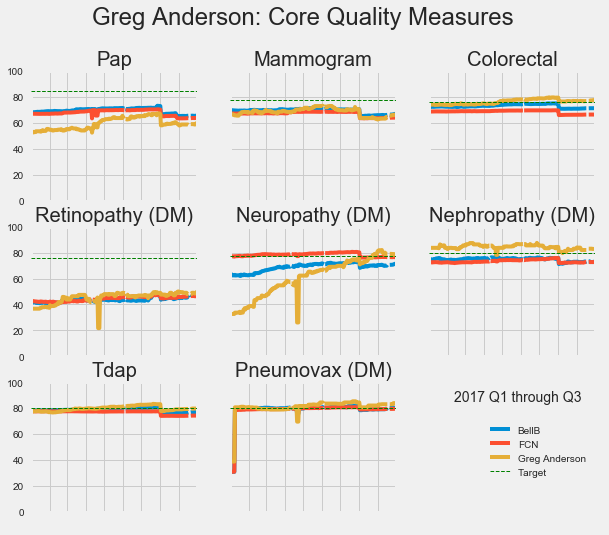

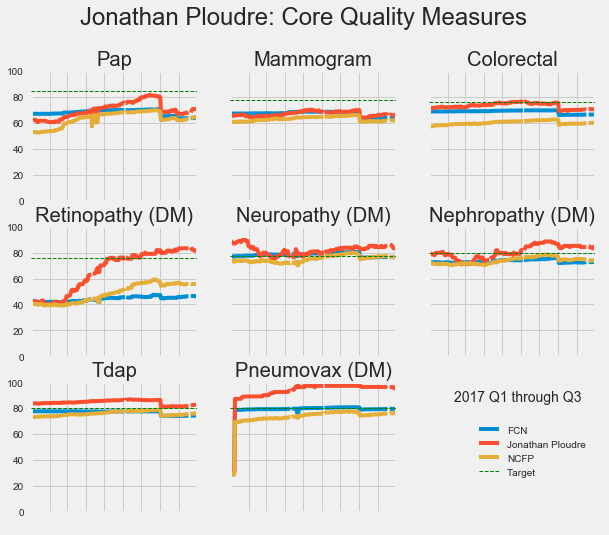

In [7]:
create_individual_core_quality_graphs("Greg_Anderson", "BellB")
create_individual_core_quality_graphs("Jonathan_Ploudre", "NCFP")

ValueError: left cannot be >= right

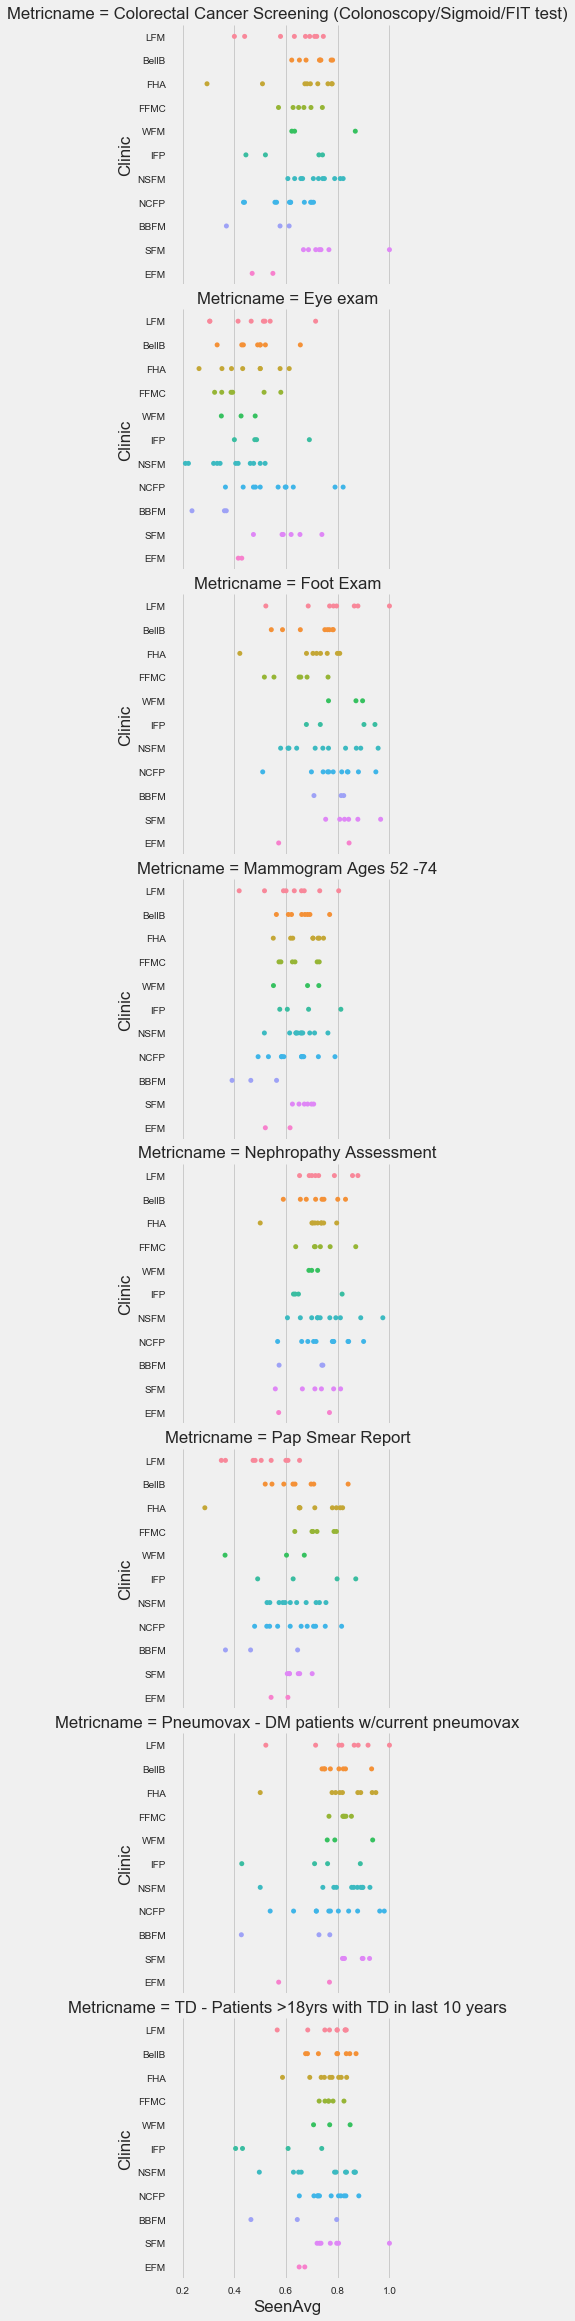

In [6]:
currentdata = pd.read_csv('./current/ProviderGroupQualityReports.csv', usecols=['NAME', 'Metricname', 'SeenAvg'])

# Add Clinic Column with lookup
providerlookup = pd.read_csv('./current/provider-clinic.csv', index_col='NAME')
currentdata['Clinic']=currentdata.NAME.map(providerlookup.CLINIC)

# Remove Clinic Data from Dataframe
#currentdata.NAME.unique()
individuals = currentdata.loc[~currentdata['NAME'].isin(['Bellingham Bay Medical Center','Birch Bay Family Medicine','Everson Family Medicine','Family Health Associates','Ferndale Family Medical Center','Island Family Physicians','Lynden Family Medicine', 'North Cascade Family Physicians','North Sound Family Medicine', 'Squalicum Family Medicine','Whatcom Family Medicine'])]

# CoreQuality is a subset of measures
#currentdata.Metricname.unique()
corequality = individuals.loc[individuals['Metricname'].isin(['Pap Smear Report','Colorectal Cancer Screening (Colonoscopy/Sigmoid/FIT test)','Mammogram Ages 52 -74','Eye exam','Foot Exam','Nephropathy Assessment','TD - Patients >18yrs with TD in last 10 years','Pneumovax - DM patients w/current pneumovax'])]
#corequality.Metricname.unique()
Factorplot = sns.factorplot(x='SeenAvg', 
                            y='Clinic', 
                            data=corequality, 
                            row='Metricname', 
                            kind="strip", 
                            orient='h')

In [7]:
def bulletgraph(data=None, limits=None, labels=None, axis_label=None, title=None,
                size=(5, 3), palette=None, formatter=None, target_color="gray",
                bar_color="black", label_color="gray"):
    """ Build out a bullet graph image
        Args:
            data = List of labels, measures and targets
            limits = list of range valules
            labels = list of descriptions of the limit ranges
            axis_label = string describing x axis
            title = string title of plot
            size = tuple for plot size
            palette = a seaborn palette
            formatter = matplotlib formatter object for x axis
            target_color = color string for the target line
            bar_color = color string for the small bar
            label_color = color string for the limit label text
        Returns:
            a matplotlib figure
    """
    # Determine the max value for adjusting the bar height
    # Dividing by 10 seems to work pretty well
    h = limits[-1] / 10

    # Use the green palette as a sensible default
    if palette is None:
        palette = sns.light_palette("green", len(limits), reverse=False)

    # Must be able to handle one or many data sets via multiple subplots
    if len(data) == 1:
        fig, ax = plt.subplots(figsize=size, sharex=True)
    else:
        fig, axarr = plt.subplots(len(data), figsize=size, sharex=True)

    # Add each bullet graph bar to a subplot
    for idx, item in enumerate(data):

        # Get the axis from the array of axes returned when the plot is created
        if len(data) > 1:
            ax = axarr[idx]

        # Formatting to get rid of extra marking clutter
        ax.set_aspect('equal')
        ax.set_yticklabels([item[0]])
        ax.set_yticks([1])
        ax.spines['bottom'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)

        prev_limit = 0
        for idx2, lim in enumerate(limits):
            # Draw the bar
            ax.barh([1], lim - prev_limit, left=prev_limit, height=h,
                    color=palette[idx2])
            prev_limit = lim
        rects = ax.patches
        # The last item in the list is the value we're measuring
        # Draw the value we're measuring
        ax.barh([1], item[1], height=(h / 3), color=bar_color)

        # Need the ymin and max in order to make sure the target marker
        # fits
        ymin, ymax = ax.get_ylim()
        ax.vlines(
            item[2], ymin * .9, ymax * .9, linewidth=1.5, color=target_color)

    # Now make some labels
    if labels is not None:
        for rect, label in zip(rects, labels):
            height = rect.get_height()
            ax.text(
                rect.get_x() + rect.get_width() / 2,
                -height * .4,
                label,
                ha='center',
                va='bottom',
                color=label_color)
    if formatter:
        ax.xaxis.set_major_formatter(formatter)
    if axis_label:
        ax.set_xlabel(axis_label)
    if title:
        fig.suptitle(title, fontsize=14)
    fig.subplots_adjust(hspace=0)

In [9]:
data_to_plot2 = [("Greg Anderson", 105, 120),
                 ("Jane Jones", 99, 110),
                 ("Fred Flintstone", 109, 125),
                 ("Barney Rubble", 135, 123),
                 ("Mr T", 45, 105)]



bulletgraph(data_to_plot2, limits=[20, 60, 100, 160],
            labels=["Poor", "OK", "Good", "Excellent"], size=(8,5),
            axis_label="Performance Measure", label_color="black",
            bar_color="#252525", target_color='#f7f7f7',
            title="Sales Rep Performance")

KeyError: 'Pap Smear Report'